## EDA

In [7]:
import pandas as pd
import numpy as np


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)
print(df.head())

             DateTime  GMT Offset  NI Generation  NI Demand  \
0 2024-01-01 00:00:00           0        715.613    584.635   
1 2024-01-01 00:15:00           0        702.913    570.701   
2 2024-01-01 00:30:00           0        799.801    563.575   
3 2024-01-01 00:45:00           0        877.653    562.830   
4 2024-01-01 01:00:00           0        872.636    577.349   

   NI Wind Generation  NI Solar Generation  IE Generation  IE Demand  \
0             249.907                  0.0        3123.41    3462.62   
1             216.946                  0.0        3127.56    3427.96   
2             301.445                  0.0        3138.09    3394.02   
3             376.547                  0.0        3112.86    3364.86   
4             378.713                  0.0        3042.50    3333.30   

   IE Wind Generation  IE Solar Generation  Hour     Day    Month  
0             2244.60                 0.10     0  Monday  January  
1             2203.77                 0.10     0  Mo

## Monthly summary statistics

Monthly Statistics for Ireland and Northern Ireland:


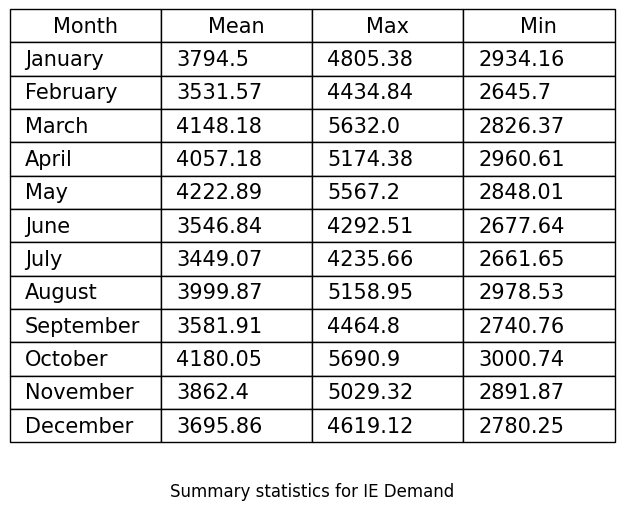

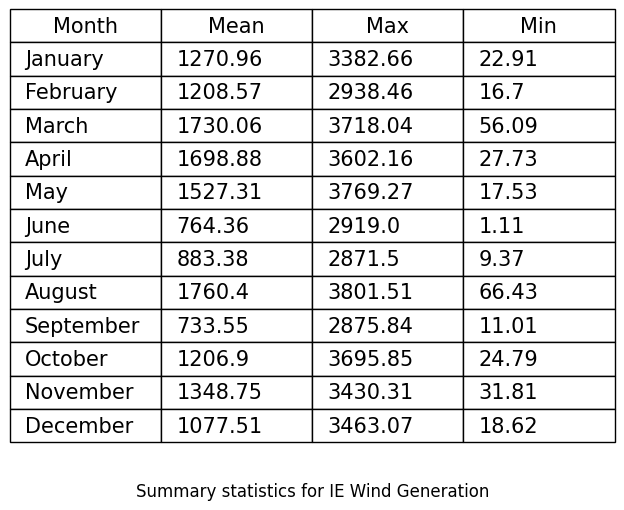

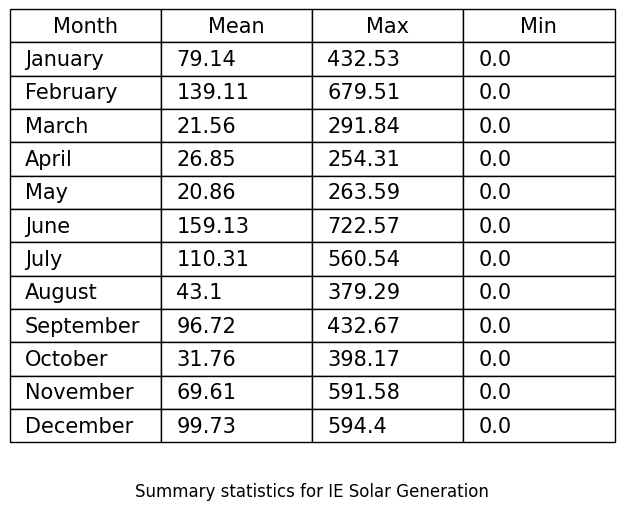

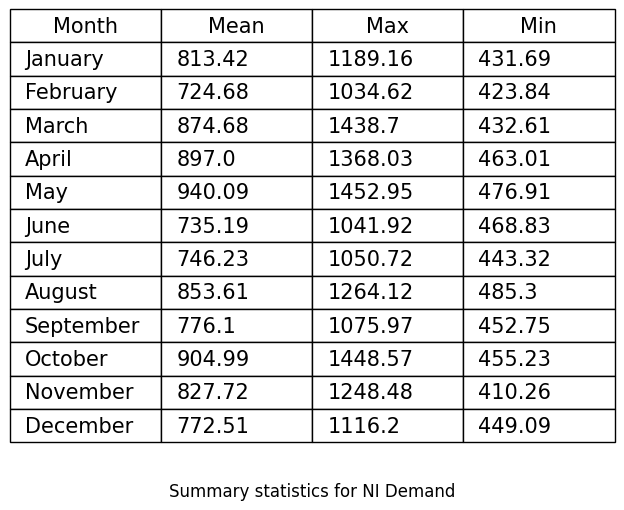

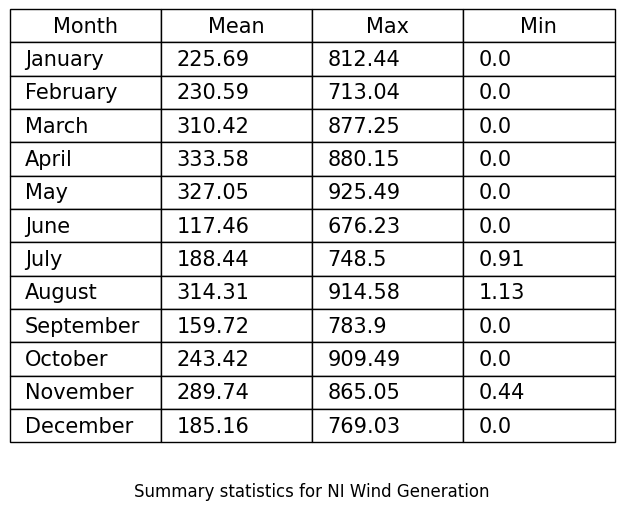

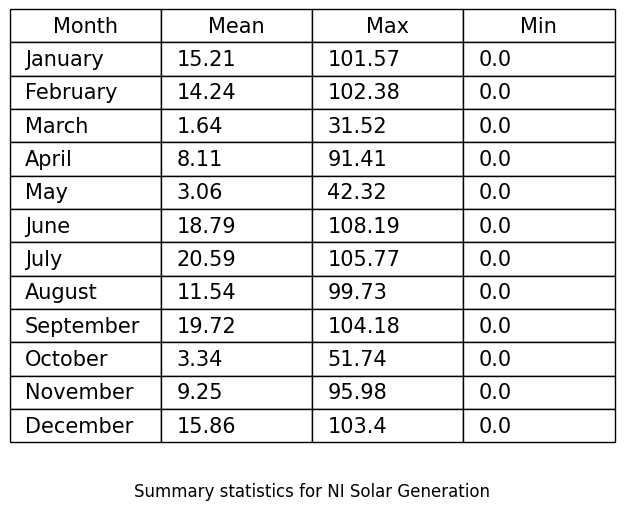

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

# compute for each month the mean, maximum, and minimum values of: IE Demand, IE Wind Generation, and IE Solar Generation
# Same for Northern Ireland (NI) : NI Demand, NI Wind Generation, and NI Solar Generation

attributes = [
    'IE Demand',
    'IE Wind Generation',
    'IE Solar Generation',
    'NI Demand',
    'NI Wind Generation',
    'NI Solar Generation'
]

months = ['January', 'February', 'March', 'April', 'May', 'June', 
                 'July', 'August', 'September', 'October', 'November', 'December']

# Aggregate data by month
agg_data = {
        attr: ['mean', 'max', 'min'] for attr in attributes
}
monthly_stats = df.groupby(df['Month']).agg(agg_data).round(2)
print("Monthly Statistics for Ireland and Northern Ireland:")
#print(monthly_stats)

# Create and display the tables for each attribute
for attr in attributes:
    
    #fill rows
    rows = []
    for index, month in enumerate(months):
        rows.append([month,monthly_stats[attr]['mean'].iloc[index],monthly_stats[attr]['max'].iloc[index],monthly_stats[attr]['min'].iloc[index]])
    
    table_data = pd.DataFrame(rows)
    
    # Plot table
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('off')  # remove axis

    # Convert DataFrame to matplotlib table
    table = ax.table(
        cellText=table_data.values,       # table values
        colLabels=['Month','Mean','Max','Min'],     # column headers
        loc='center',
        cellLoc='left'
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1.3, 2)

    plt.title(f'Summary statistics for {attr}',y=-1.3, loc='center', pad=5) 
    plt.show()



## Time series Analysis


                     IE Demand  IE Generation  NI Demand  NI Generation
DateTime                                                               
2024-01-01 00:00:00    3462.62        3123.41    584.635        715.613
2024-01-01 00:15:00    3427.96        3127.56    570.701        702.913
2024-01-01 00:30:00    3394.02        3138.09    563.575        799.801
2024-01-01 00:45:00    3364.86        3112.86    562.830        877.653
2024-01-01 01:00:00    3333.30        3042.50    577.349        872.636


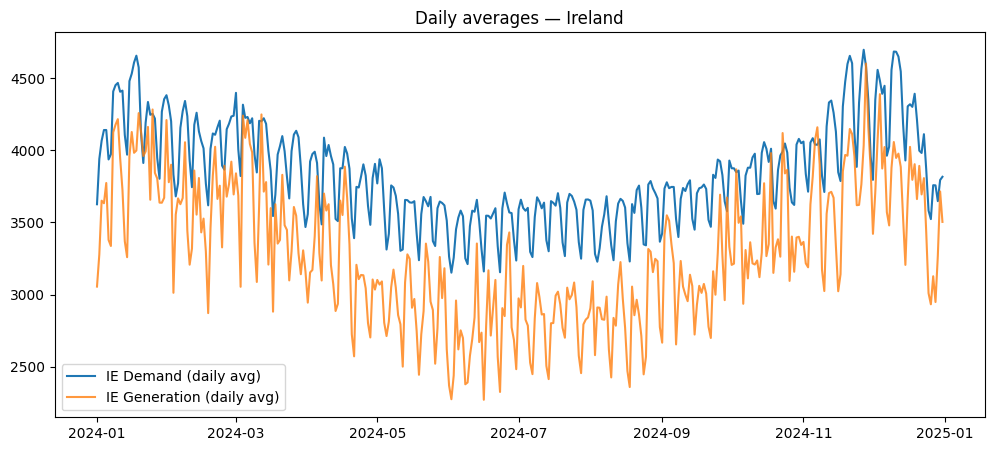

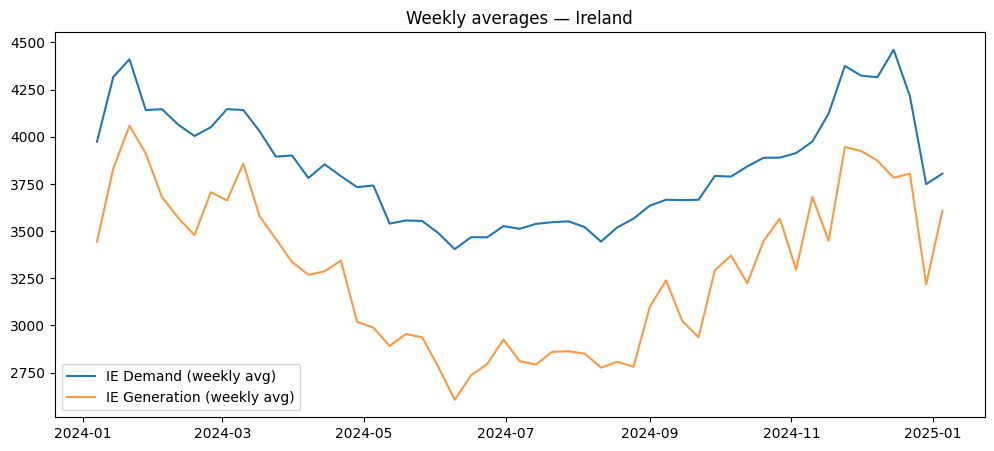

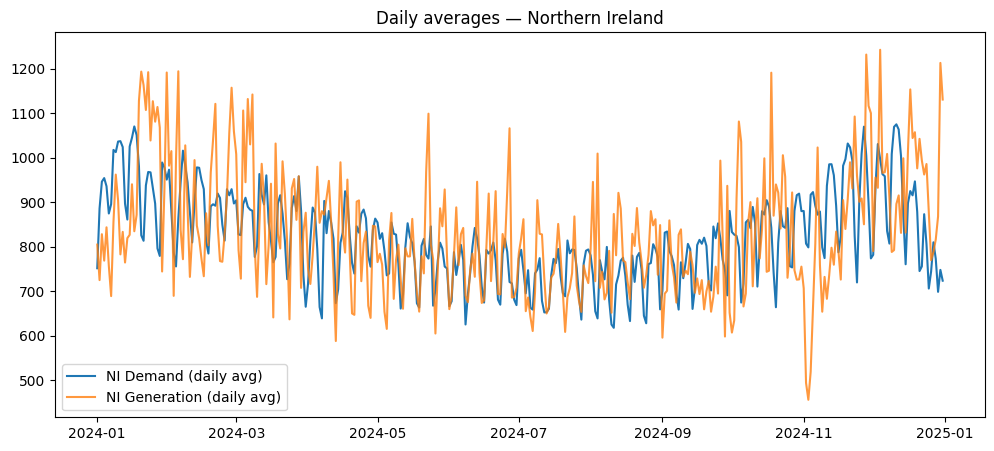

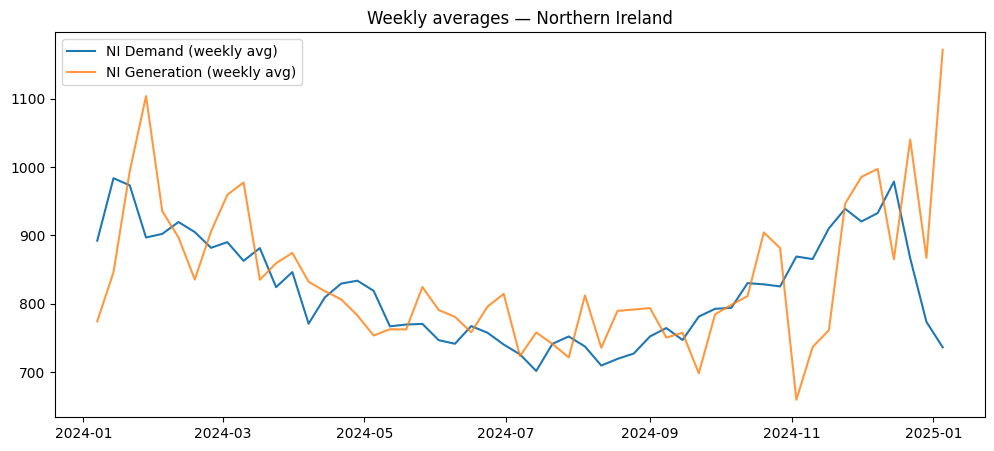

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

attributes = [
    'DateTime',
    'IE Demand',
    'IE Generation',
    'NI Demand',
    'NI Generation',
]

# Filter attributes and Set datetime as index
df_time = df.get(attributes).set_index('DateTime')

print(df_time.head())


# Daily averages (we resample daily)
daily = df_time.resample('D').mean()

# Weekly averages (we resample weekly)
weekly = df_time.resample('W').mean()

# Plot time series

# IE Demand daily
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['IE Demand'], label='IE Demand (daily avg)')
plt.plot(daily.index, daily['IE Generation'], label='IE Generation (daily avg)', alpha=0.8)
plt.title('Daily averages — Ireland')
plt.legend()
plt.show()

# IE Demand weekly
plt.figure(figsize=(12,5))
plt.plot(weekly.index, weekly['IE Demand'], label='IE Demand (weekly avg)')
plt.plot(weekly.index, weekly['IE Generation'], label='IE Generation (weekly avg)', alpha=0.8)
plt.title('Weekly averages — Ireland')
plt.legend()
plt.show()


# NI Demand daily
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['NI Demand'], label='NI Demand (daily avg)')
plt.plot(daily.index, daily['NI Generation'], label='NI Generation (daily avg)', alpha=0.8)
plt.title('Daily averages — Northern Ireland')
plt.legend()
plt.show()

# IE Demand weekly
plt.figure(figsize=(12,5))
plt.plot(weekly.index, weekly['NI Demand'], label='NI Demand (weekly avg)')
plt.plot(weekly.index, weekly['NI Generation'], label='NI Generation (weekly avg)', alpha=0.8)
plt.title('Weekly averages — Northern Ireland')
plt.legend()
plt.show()




## Autocorrelation analysis

                     IE Wind Generation  IE Solar Generation  \
DateTime                                                       
2024-01-01 00:00:00             2244.60                 0.10   
2024-01-01 00:15:00             2203.77                 0.10   
2024-01-01 00:30:00             2193.46                 0.10   
2024-01-01 00:45:00             2163.40                 0.09   
2024-01-01 01:00:00             2109.65                 0.10   

                     NI Wind Generation  NI Solar Generation  
DateTime                                                      
2024-01-01 00:00:00             249.907                  0.0  
2024-01-01 00:15:00             216.946                  0.0  
2024-01-01 00:30:00             301.445                  0.0  
2024-01-01 00:45:00             376.547                  0.0  
2024-01-01 01:00:00             378.713                  0.0  


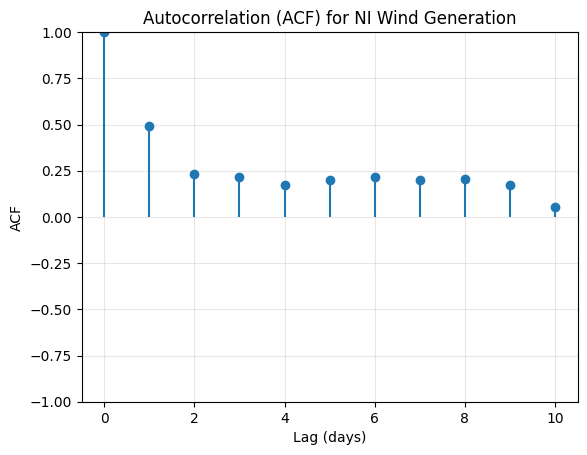

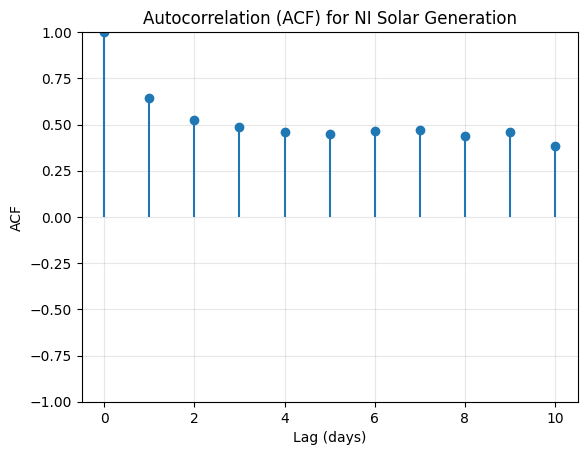

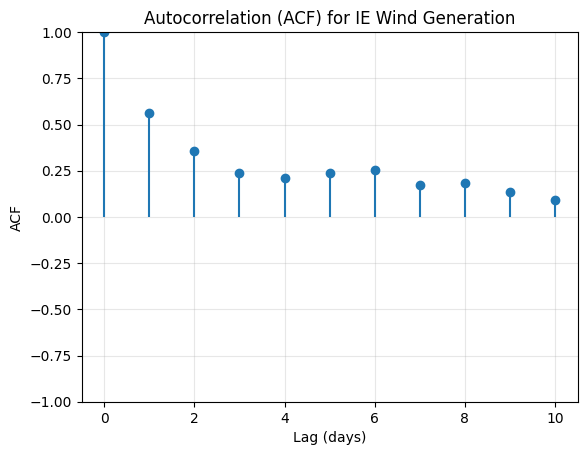

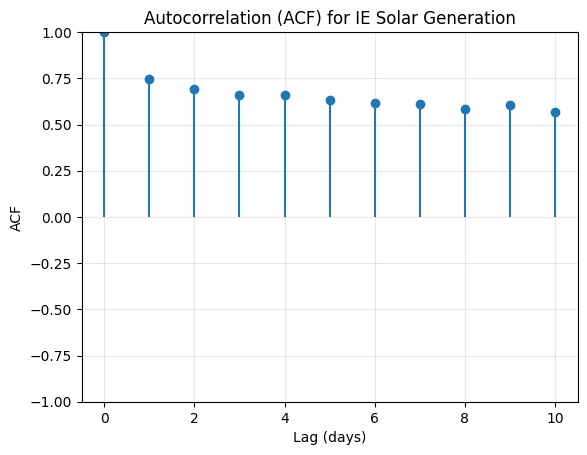

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

attributes = [
    'DateTime',
    'IE Wind Generation',
    'IE Solar Generation',
    'NI Wind Generation',
    'NI Solar Generation',
]

# Filter attributes and Set datetime as index
df_time = df.get(attributes).set_index('DateTime')

print(df_time.head())


# Daily averages (we resample daily)
daily = df_time.resample('D').mean()

# Weekly averages (we resample weekly)
weekly = df_time.resample('W').mean()

# Max lags 10 days
max_lag = 10  

# Series names
series_names = [
    ('NI Wind Generation', 'NI Wind Generation'),
    ('NI Solar Generation', 'NI Solar Generation'),
    ('IE Wind Generation', 'IE Wind Generation'),
    ('IE Solar Generation', 'IE Solar Generation')
]

for label, col in series_names:
    # use daily series
    series = daily[col].dropna()
    acfs = acf(series, nlags=max_lag, fft=False)
    plt.figure()
    plt.stem(range(len(acfs)), acfs, basefmt=" ")
    plt.xlabel('Lag (days)')
    plt.ylabel('ACF')
    plt.title(f'Autocorrelation (ACF) for {label}')
    plt.ylim(-1,1)
    plt.grid(alpha=0.3)
    plt.show()
    

## Monthly Averaging time series data

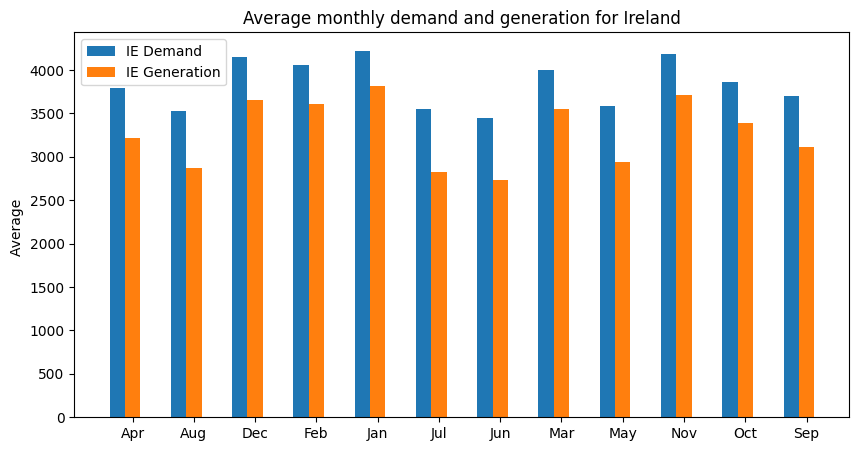

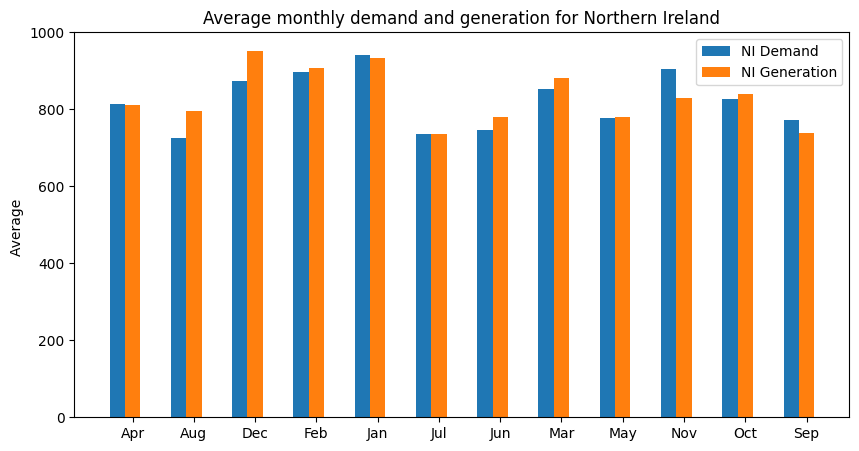

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

cols = [
    'DateTime',
    'Month',
    'IE Demand',
    'NI Demand',
    'IE Generation',
    'NI Generation',
]


monthly_of_year = df[cols].groupby('Month').mean()
monthly_of_year.index = monthly_of_year.index.str[:3]

# Create bar chart: IE demand by month
plt.figure(figsize=(10,5))
x = np.arange(len(monthly_of_year.index))
width = 0.25
plt.bar(x - width, monthly_of_year['IE Demand'], width=width, label='IE Demand')
plt.bar(x, monthly_of_year['IE Generation'], width=width, label='IE Generation')
plt.xticks(x, monthly_of_year.index)
plt.ylabel('Average ')
plt.title('Average monthly demand and generation for Ireland')
plt.legend()
plt.show()

# Create bar chart: NI demand by month
plt.figure(figsize=(10,5))
plt.bar(x - width, monthly_of_year['NI Demand'], width=width, label='NI Demand')
plt.bar(x, monthly_of_year['NI Generation'], width=width, label='NI Generation')
plt.xticks(x, monthly_of_year.index)
plt.ylabel('Average ')
plt.title('Average monthly demand and generation for Northern Ireland')
plt.legend()
plt.show()


## Daily generation proﬁle

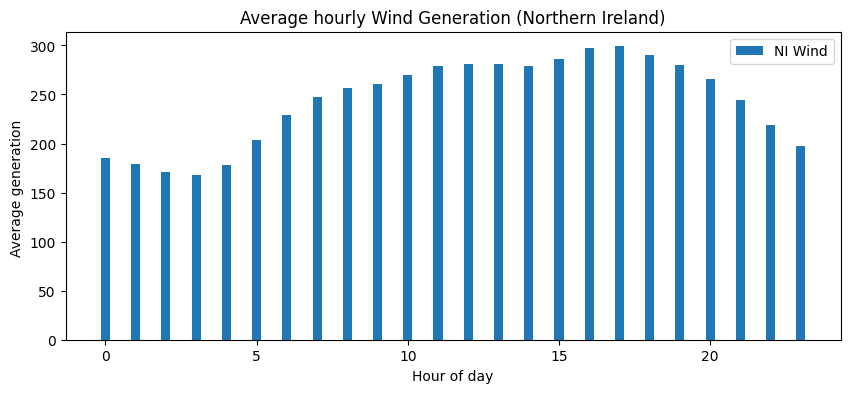

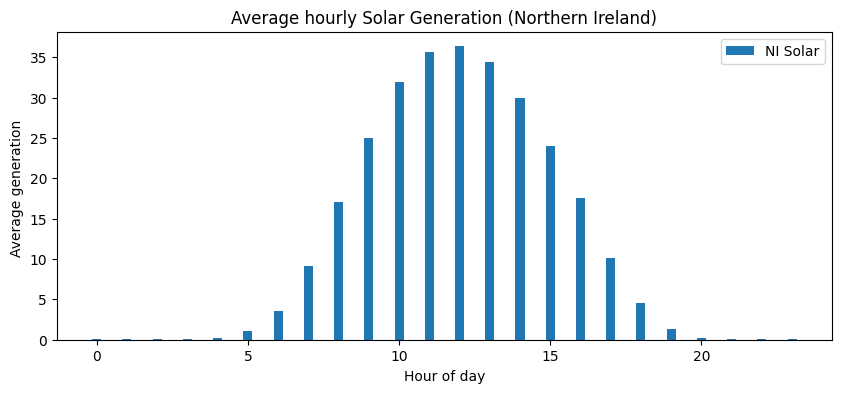

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

cols = [
    'DateTime',
    'Hour',
    'IE Wind Generation',
    'IE Solar Generation',
    'NI Wind Generation',
    'NI Solar Generation',
]

hourly = df[cols].groupby('Hour').mean()

# Plot hourly bar chart for NI - Wind Generation
plt.figure(figsize=(10,4))
plt.bar(hourly.index, hourly['NI Wind Generation'], width=0.3, label='NI Wind')
plt.xlabel('Hour of day')
plt.ylabel('Average generation ')
plt.title('Average hourly Wind Generation (Northern Ireland)')
plt.legend()
plt.show()

# Plot hourly bar chart for NI - Solar Generation
plt.figure(figsize=(10,4))
plt.bar(hourly.index, hourly['NI Solar Generation'], width=0.3, label='NI Solar')
plt.xlabel('Hour of day')
plt.ylabel('Average generation ')
plt.title('Average hourly Solar Generation (Northern Ireland)')
plt.legend()
plt.show()



## Weekly proﬁle

                     IE Demand  IE Generation  NI Demand  NI Generation
DateTime                                                               
2024-01-01 00:00:00    3462.62        3123.41    584.635        715.613
2024-01-01 00:15:00    3427.96        3127.56    570.701        702.913
2024-01-01 00:30:00    3394.02        3138.09    563.575        799.801
2024-01-01 00:45:00    3364.86        3112.86    562.830        877.653
2024-01-01 01:00:00    3333.30        3042.50    577.349        872.636


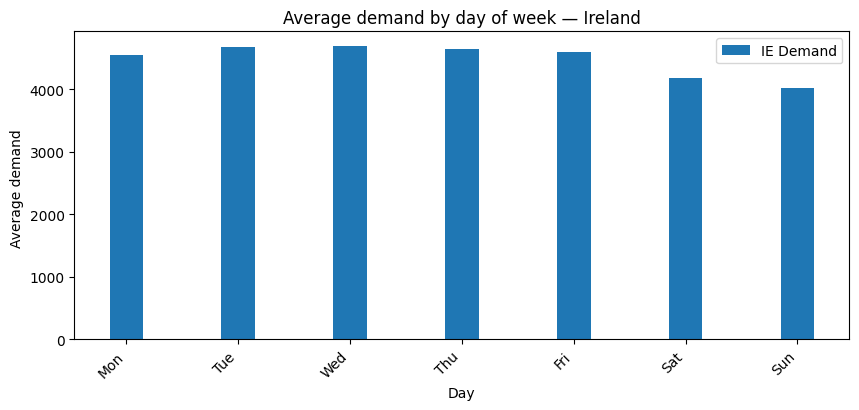

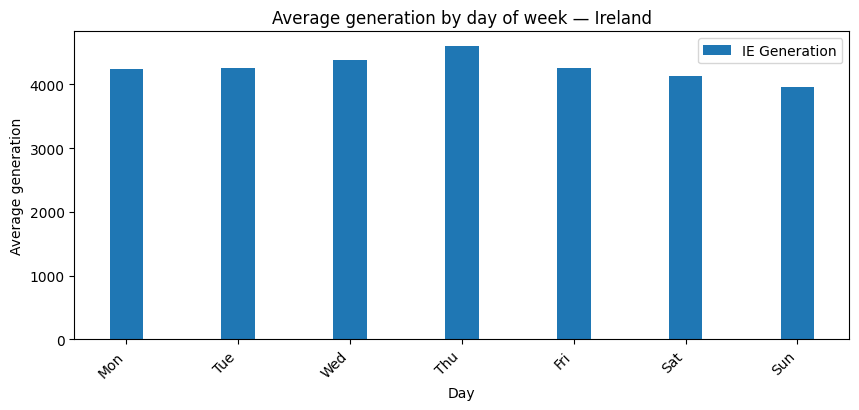

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

cols = [
    'DateTime',
    'IE Demand',
    'IE Generation',
    'NI Demand',
    'NI Generation',
]

weekday_map = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

df_time = df.get(cols).set_index('DateTime')

print(df_time.head())

# Daily averages (we resample daily)
dow = df_time.resample('D').mean()
dow.index = dow.index.day_of_week

# plot demand for IE by day of week
plt.figure(figsize=(10,4))
plt.bar( dow.index, dow['IE Demand'], width=0.3, label='IE Demand')
plt.xticks(ticks=np.arange(len(weekday_map)), labels=weekday_map, rotation=45, ha='right')
plt.xlabel('Day')
plt.ylabel('Average demand ')
plt.title('Average demand by day of week — Ireland')
plt.legend()
plt.show()

# plot generation for IE by day of week
plt.figure(figsize=(10,4))
plt.bar(dow.index, dow['IE Generation'], width=0.3, label='IE Generation')
plt.xticks(ticks=np.arange(len(weekday_map)), labels=weekday_map, rotation=45, ha='right')
plt.xlabel('Day')
plt.ylabel('Average generation')
plt.title('Average generation by day of week — Ireland')
plt.legend()
plt.show()



## Variations of the daily demand proﬁles

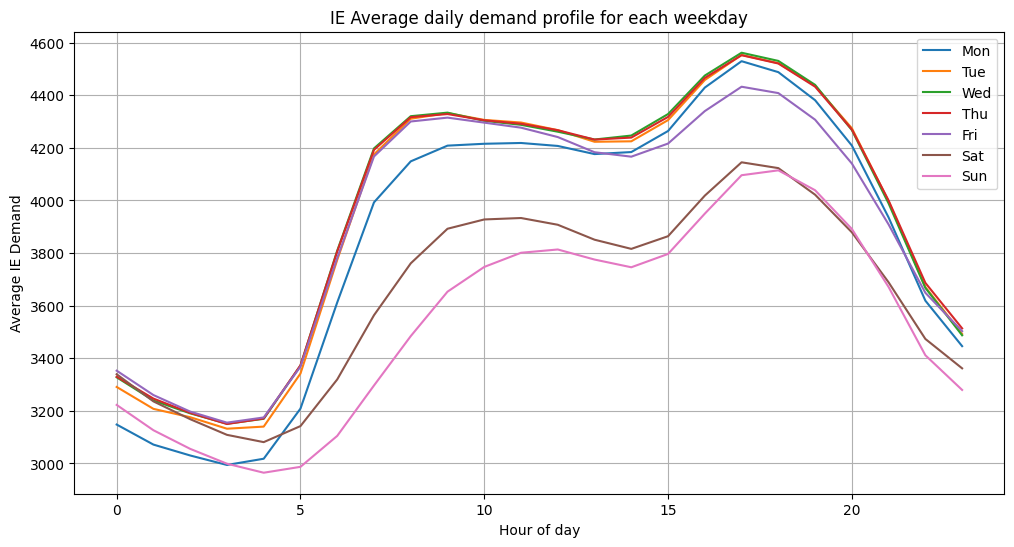

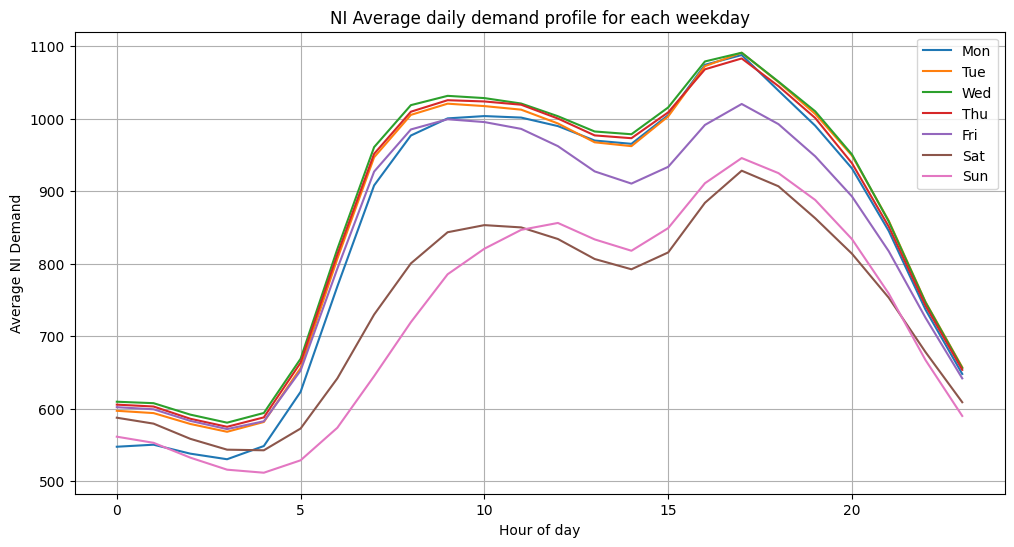

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)

cols = [
    'DateTime',
    'Day',
    'Hour',
    'IE Demand',
    'IE Generation',
    'NI Demand',
    'NI Generation',
]


weekday_map = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
weekday_name = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Set DateTime index
df_time = df.get(cols).set_index('DateTime')
profiles = df_time.copy()

# IE
# Mean for each (weekday, hour)
profile_means = profiles.groupby(['Day','Hour'])['IE Demand'].mean().unstack(level=0) 
# Plot separate lines for each weekday

plt.figure(figsize=(12,6))
for wd in range(7):
    plt.plot(profile_means.index, profile_means[weekday_name[wd]], label=weekday_map[wd])
plt.xlabel('Hour of day')
plt.ylabel('Average IE Demand')
plt.title('IE Average daily demand profile for each weekday')
plt.legend()
plt.grid(True)
plt.show()

# NI
# Mean for each (weekday, hour)
profile_means = profiles.groupby(['Day','Hour'])['NI Demand'].mean().unstack(level=0) 
# Plot separate lines for each weekday

plt.figure(figsize=(12,6))
for wd in range(7):
    plt.plot(profile_means.index, profile_means[weekday_name[wd]], label=weekday_map[wd])
plt.xlabel('Hour of day')
plt.ylabel('Average NI Demand')
plt.title('NI Average daily demand profile for each weekday')
plt.legend()
plt.grid(True)
plt.show()


## Demand and generation between weekend and weekday

In [18]:
import pandas as pd
import numpy as np
from scipy import stats


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)


# Set DateTime index
df_time = df.set_index('DateTime')

is_weekend = df_time.index.weekday.isin([5,6])


# Demand
# IE: weekday and weekend demand
ie_weekend = df_time.loc[is_weekend, 'IE Demand'].dropna()
ie_weekday = df_time.loc[~is_weekend, 'IE Demand'].dropna()

# Two-sided Two-sample t-test
# Ho: u1 - u2 = 0
# Ha: u1 - u2 != 0
t_stat_ie, pval_ie = stats.ttest_ind(ie_weekend, ie_weekday, equal_var=False)
print("IE Demand t-stat:", t_stat_ie, "p-value:", pval_ie)
#IE Demand t-stat: -55.94682505412931 p-value: 0.0

# NI: weekday and weekend demand
ni_weekend = df_time.loc[is_weekend, 'NI Demand'].dropna()
ni_weekday = df_time.loc[~is_weekend, 'NI Demand'].dropna()
t_stat_ni, pval_ni = stats.ttest_ind(ni_weekend, ni_weekday, equal_var=False)
print("NI Demand t-stat:", t_stat_ni, "p-value:", pval_ni)
# NI Demand t-stat: -58.29314116760549 p-value: 0.0


# Solar Generation
# IE: weekday and weekend solar generation
ie_weekend = df_time.loc[is_weekend, 'IE Solar Generation'].dropna()
ie_weekday = df_time.loc[~is_weekend, 'IE Solar Generation'].dropna()

# Two-sided Two-sample t-test
# Ho: u1 - u2 = 0
# Ha: u1 - u2 != 0
t_stat_ie, pval_ie = stats.ttest_ind(ie_weekend, ie_weekday, equal_var=False)
print("IE Solar Generation t-stat:", t_stat_ie, "p-value:", pval_ie)
#IE Solar Generation t-stat: -0.8115315112032591 p-value: 0.4170710229447584

# NI: weekday and weekend solar generation
ni_weekend = df_time.loc[is_weekend, 'NI Solar Generation'].dropna()
ni_weekday = df_time.loc[~is_weekend, 'NI Solar Generation'].dropna()
t_stat_ni, pval_ni = stats.ttest_ind(ni_weekend, ni_weekday, equal_var=False)
print("NI Solar Generation t-stat:", t_stat_ni, "p-value:", pval_ni)
# NI Solar Generation t-stat: 0.5518344002573795 p-value: 0.5810688041799088


IE Demand t-stat: -55.94682505412931 p-value: 0.0
NI Demand t-stat: -58.29314116760549 p-value: 0.0
IE Solar Generation t-stat: -0.8115315112032591 p-value: 0.4170710229447584
NI Solar Generation t-stat: 0.5518344002573795 p-value: 0.5810688041799088


## Wind Penetration Rate

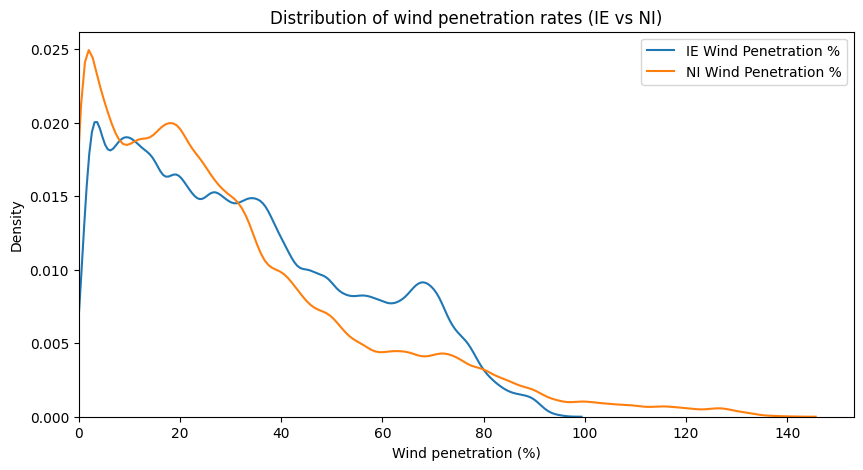

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns


def clean_dataset(datafile,separator=',',rows_to_skip=0):
    """
   Read the datafile cleaning any missing or negative values using interpolation.
   Drop the duplicate rows.
   Convert the DateTime UTC column into local Ireland time using the GMT Offset column
   Generate datetime features such as hour, day, and month for further analysis
   Return a cleaned DataFrame.
    """
    
    df = pd.DataFrame()
    # Xlsx file handling
    if datafile.endswith('.xlsx') or datafile.endswith('.xls'):
        df = pd.read_excel(datafile, skiprows=rows_to_skip)
    else:
        # Read our data file as chunks
        csv_chunks = pd.read_csv(datafile, chunksize=100000, sep=separator,skiprows=rows_to_skip)
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(csv_chunks, ignore_index=True)
            
    # Drop duplicate rows
    df = df.drop_duplicates()
    # Replace negative values with NaN
    df = df.map(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)
    # Interpolate missing values
    df = df.interpolate(method='linear', limit_direction='both')
    
    #print(df.head())
    
    # Convert DateTime column to local Ireland time using GMT Offset column
    if 'DateTime' in df.columns and 'GMT Offset' in df.columns:
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') # convert into python datetime objects
        df['GMT Offset'] = pd.to_numeric(df['GMT Offset'], errors='coerce') # convert GMT offsets into numeric values
        # For each row in the dataset, substract the GMT Offset
        df['DateTime'] = df.apply(lambda row: row['DateTime'] - pd.Timedelta(hours=row['GMT Offset']) if pd.notnull(row['DateTime']) and pd.notnull(row['GMT Offset']) else pd.NaT, axis=1)
    
    #print(df.head())
    # Generate datetime features
    if 'DateTime' in df.columns or df.index.name == 'DateTime':
        df['Hour'] = df['DateTime'].dt.hour
        df['Day'] = df['DateTime'].dt.day_name(locale='en_US')
        df['Month'] = df['DateTime'].dt.month_name(locale='en_US')
    
    return df


datafile = 'System_Data_Qtr_Hourly_2024.xlsx'
df = clean_dataset(datafile, separator=',', rows_to_skip=0)



df['IE Wind Penetration %'] = (df['IE Wind Generation'] / df['IE Demand']) * 100
df['NI Wind Penetration %'] = (df['NI Wind Generation'] / df['NI Demand']) * 100


# Plot distributions on a single graph
plt.figure(figsize=(10,5))
sns.kdeplot(df['IE Wind Penetration %'].dropna(), label='IE Wind Penetration %', bw_adjust=0.5)
sns.kdeplot(df['NI Wind Penetration %'].dropna(), label='NI Wind Penetration %', bw_adjust=0.5)
plt.xlim(0, None)
plt.xlabel('Wind penetration (%)')
plt.title('Distribution of wind penetration rates (IE vs NI)')
plt.legend()
plt.show()

